# Statistical seismology and the Parkfield region
> Herein, you'll use your statistical thinking skills to study the frequency and magnitudes of earthquakes. Along the way, you'll learn some basic statistical seismology, including the Gutenberg-Richter law. This exercise exposes two key ideas about data science 1) As a data scientist, you wander into all sorts of domain specific analyses, which is very exciting. You constantly get to learn. 2) You are sometimes faced with limited data, which is also the case for many of these earthquake studies. This is the Summary of lecture "Case Studies in Statistical Thinking", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Statistics]
- image: images/compare_exp_norm.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dc_stat_think as dcst

plt.rcParams['figure.figsize'] = (10, 5)

## Introduction to statistical seismology and the Parkfield experiment
- The Gutenberg-Richter Law
The magnitudes of earthquakes in a given region over a given time period are exponentially distributed. 

One parameter, given by $\bar{m} - m_t$, describes earthquake magnitude
- Completeness threshold
The magnitude $m_t$, above which all earthquakes in a region can be detected

### Parkfield earthquake magnitudes
As usual, you will start with EDA and plot the ECDF of the magnitudes of earthquakes detected in the Parkfield region from 1950 to 2016. The magnitudes of all earthquakes in the region from the ANSS ComCat are stored in the Numpy array `mags`.

When you do it this time, though, take a shortcut in generating the ECDF. You may recall that putting an asterisk before an argument in a function splits what follows into separate arguments. Since `dcst.ecdf()` returns two values, we can pass them as the x, y positional arguments to `plt.plot()` as `plt.plot(*dcst.ecdf(data_you_want_to_plot))`.

You will use this shortcut in this exercise and going forward.

In [2]:
df = pd.read_csv('./dataset/parkfield_earthquakes_1950-2017.csv', skiprows=2, index_col=0, parse_dates=True)
df.head()

latitude   longitude  depth   mag magType   nst  \
time                                                                        
1951-10-03 13:44:33.170  35.869333 -120.451000    6.0  3.67      ml   6.0   
1953-05-28 07:58:34.510  36.004167 -120.501167    6.0  3.61      ml   7.0   
1961-12-14 11:51:15.410  35.970000 -120.470167    6.0  3.95      ml  12.0   
1965-02-21 18:39:24.500  35.881000 -120.383500    6.0  3.54      ml  10.0   
1966-06-28 04:18:36.180  35.856500 -120.446167    6.0  3.15      ml   7.0   

                           gap    dmin   rms net  ... depthError magError  \
time                                              ...                       
1951-10-03 13:44:33.170  259.0  1.5480  0.43  ci  ...      31.61    0.154   
1953-05-28 07:58:34.510  296.0  0.9139  0.39  ci  ...      31.61      NaN   
1961-12-14 11:51:15.410  297.0  0.8718  0.51  ci  ...      31.61    0.070   
1965-02-21 18:39:24.500  257.0  1.5380  0.56  ci  ...      31.61    0.048   
1966-06-28 04:18:36.180  259.0  1.3120  0.32  ci  ...      31.61    0.105   

                        magNst    status  locationSource  magSource  loc_name  \
time                                                                            
1951-10-03 13:44:33.170   10.0  reviewed              ci         ci   Shandon   
1953-05-28 07:58:34.510    1.0  reviewed              ci         ci  Coalinga   
1961-12-14 11:51:15.410   11.0  reviewed              ci         ci  Coalinga   
1965-02-21 18:39:24.500   11.0  reviewed              ci         ci   Shandon   
1966-06-28 04:18:36.180    7.0  reviewed              ci         ci   Shandon   

                         loc_admin1              loc_admin2 loc_cc  
time                                                                
1951-10-03 13:44:33.170  California  San Luis Obispo County     US  
1953-05-28 07:58:34.510  California           Fresno County     US  
1961-12-14 11:51:15.410  California           Fresno County     US  
1965-02-21 18:39:24.500  California  San Luis Obispo County     US  
1966-06-28 04:18:36.180  California  San Luis Obispo County     US  

[5 rows x 25 columns]

In [3]:
mags = df['mag'].to_numpy()

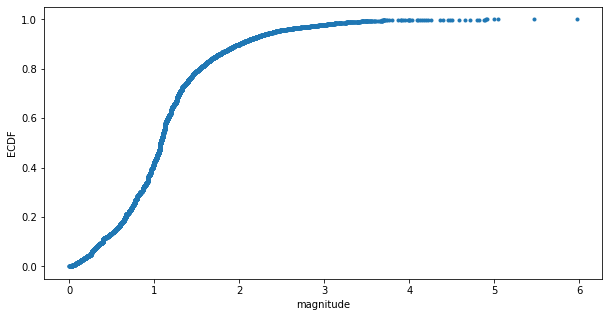

In [4]:
# Make the plot
_ = plt.plot(*dcst.ecdf(mags), marker='.', linestyle='none')

# Label axes
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')

Note the distinctive roll-off at magnitudes below 1.0.

### Computing the b-value
The b-value is a common metric for the seismicity of a region. You can imagine you would like to calculate it often when working with earthquake data. For tasks like this that you will do often, it is best to write a function! So, write a function with signature `b_value(mags, mt, perc=[2.5, 97.5], n_reps=None)` that returns the b-value and (optionally, if `n_reps` is not None) its confidence interval for a set of magnitudes, `mags`. The completeness threshold is given by `mt`. The perc keyword argument gives the percentiles for the lower and upper bounds of the confidence interval, and `n_reps` is the number of bootstrap replicates to use in computing the confidence interval.

In [5]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]
    
    # Compute b-value: b
    b = (np.mean(m) - mt) * np.log(10)
    
    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, n_reps)
        
        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)
        
        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
        
        return b, conf_int

### The b-value for Parkfield
The ECDF is effective at exposing roll-off, as you could see below magnitude 1. Because there are plenty of earthquakes above magnitude 3, you can use mt = 3 as your completeness threshold. With this completeness threshold, compute the b-value for the Parkfield region from 1950 to 2016, along with the 95% confidence interval. Print the results to the screen. The variable mags with all the magnitudes is in your namespace.

Overlay the theoretical Exponential CDF to verify that the Parkfield region follows the Gutenberg-Richter Law.


b-value: 1.08
95% conf int: [0.94, 1.24]


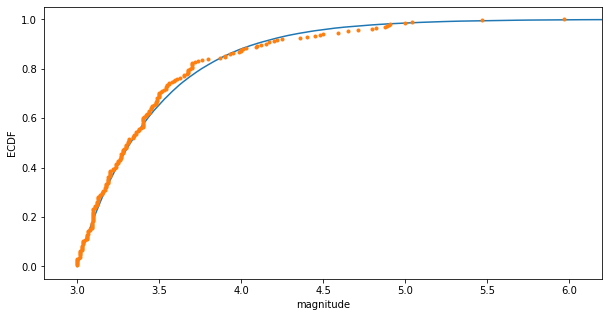

In [6]:
mt = 3
# Compute b-value and 95% confidence interval
b, conf_int = b_value(mags, mt=3, perc=[2.5, 97.5], n_reps=10000)

# Generate samples to for theoretical ECDF
m_theor = np.random.exponential(b / np.log(10), size=100000) + mt

# Plot the theoretical CDF
_ = plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF (slicing mags >= mt)
_ = plt.plot(*dcst.ecdf(mags[mags >= mt]), marker='.', linestyle='none')

# Pretty up and show the plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(2.8, 6.2)

# Report the results
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

## Timing of major earthquakes and the Parkfield sequence
- Models for earthquake timing
    - Exponential: Earthquakes happen like a Poisson process
    - Gaussian: Earthquakes happen with a well-defined period

### Interearthquake time estimates for Parkfield
In this exercise, you will first compute the best estimates for the parameters for the Exponential and Gaussian models for interearthquake times. You will then plot the theoretical CDFs for the respective models along with the formal ECDF of the actual Parkfield interearthquake times.



In [7]:
time_gap = np.array([24.06570842, 20.07665982, 21.01848049, 12.24640657, 32.05475702,
       38.2532512 ])

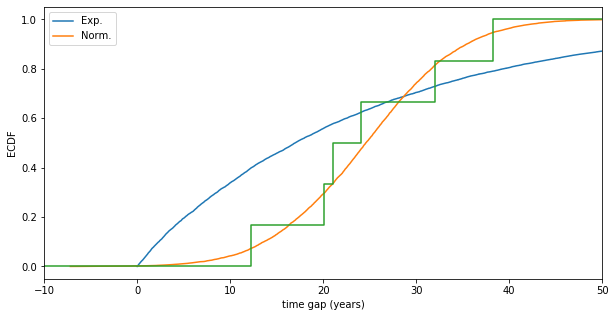

In [11]:
# Compute the mean time gap: mean_time_gap
mean_time_gap = np.mean(time_gap)

# Standard deviation of the time gap: std_time_gap
std_time_gap = np.std(time_gap)

# Generate theoretical Exponential distribution of timings: time_gap_exp
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

# Generate theoretical Normal distribution of timings: time_gap_norm
time_gap_norm = np.random.normal(loc=mean_time_gap, scale=std_time_gap, size=10000)

# Plot theoretical CDFs
_ = plt.plot(*dcst.ecdf(time_gap_exp))
_ = plt.plot(*dcst.ecdf(time_gap_norm))

# Plot Parkfield ECDF
_ = plt.plot(*dcst.ecdf(time_gap, formal=True, min_x=-10, max_x=50))

# Add legend
_ = plt.legend(('Exp.', 'Norm.'), loc='upper left')

# Label axes, set limits and show plot
_ = plt.xlabel('time gap (years)')
_ = plt.ylabel('ECDF')
_ = plt.xlim(-10, 50)

By eye, the Gaussian model seems to describe the observed data best. We will investigate the consequences of this in the next exercise, and see if we can reject the Exponential model in coming exercises.

### When will the next big Parkfield quake be?
The last big earthquake in the Parkfield region was on the evening of September 27, 2004 local time. Your task is to get an estimate as to when the next Parkfield quake will be, assuming the Exponential model and also the Gaussian model. In both cases, the best estimate is given by the mean time gap, which you computed in the last exercise to be 24.62 years, meaning that the next earthquake would be in 2029. Compute 95% confidence intervals on when the next earthquake will be assuming an Exponential distribution parametrized by `mean_time_gap` you computed in the last exercise. Do the same assuming a Normal distribution parametrized by `mean_time_gap` and `std_time_gap`.


In [12]:
today = 2020.4788213099084
last_quake = 2004.74

In [13]:
# Draw samples from the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# Draw samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(loc=mean_time_gap, scale=std_time_gap, size=100000)

# No earthquake as of today, so only keep samples that are long enough
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

# Compute the confidence intervals with medians
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

# Print the results
print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)

Exponential: [2021.0975347  2037.57861642 2111.80906838]
     Normal: [2021.27520233 2030.97032934 2046.38291392]


The models given decidedly different predictions. The Gaussian model says the next earthquake is almost sure to be in the next few decades, but the Exponential model says we may very well have to wait longer.

## How are the Parkfield interearthquake times distributed?
- Hypothesis test on the Nankai megathrust earthquakes
    - Hypothesis: The time between Nankai Trough earthquakes is normally distributed with a mean and standard deviation as calculated from the data
    - Test Statistic: ??
    - At least as extreme as: ??
- Kolmogorov-Smirnov test (or K-S test)
    - Hypothesis: same as above
    - Test statistic: Kolmogorov-Smirnov statistic
    - At least as extreme as: $\geq$ observed K-S statistic
- Simulating the null hypothesis
    - Draw lots of samples out of the theoretical distribution and store them
        - Draw n samples out of the theoretical distribution
        - Compute the K-S statistic from the samples

### Computing the K-S statistic
Write a function to compute the Kolmogorov-Smirnov statistic from two datasets, `data1` and `data2`, in which `data2` consists of samples from the theoretical distribution you are comparing your data to. Note that this means we are using hacker stats to compute the K-S statistic for a dataset and a theoretical distribution, not the K-S statistic for two empirical datasets.

In [14]:
def ks_stat(data1, data2):
    # Compute ECDF from data: x, y
    x, y = dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = dcst.ecdf_formal(x, data2)
    
    # Compute distances between concave corners and CDF
    D_top =  y - cdf
    
    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1 / len(data1)
    
    return np.max((D_top, D_bottom))

### Drawing K-S replicates
Now, you need a function to draw Kolmogorov-Smirnov replicates out of a target distribution, f. Construct a function with signature `draw_ks_reps(n, f, args=(), size=10000, n_reps=10000)` to do so. Here, `n` is the number of data points, and `f` is the function you will use to generate samples from the target CDF. For example, to test against an Exponential distribution, you would pass `np.random.exponential` as `f`. This function usually takes arguments, which must be passed as a tuple. So, if you wanted to take samples from an Exponential distribution with mean `x_mean`, you would use the `args=(x_mean,)` keyword. The keyword arguments `size` and `n_reps` respectively represent the number of samples to take from the target distribution and the number of replicates to draw.

In [15]:
def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
    # Generate samples from target distribution
    x_f = f(*args, size=size)
    
    # Initialize K-S replicates
    reps = np.empty(shape=n_reps)
    
    # Draw replicates
    for i in range(n_reps):
        # Draw samples for comparison
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = dcst.ks_stat(x_f, x_samp)
        
    return reps

This will allow you to draw K-S replicates for use in K-S tests for arbitrary continuous distributions. You'll put it to use in the next exercise.

### The K-S test for Exponentiality
Test the null hypothesis that the interearthquake times of the Parkfield sequence are Exponentially distributed. That is, earthquakes happen at random with no memory of when the last one was. Note: This calculation is computationally intensive (you will draw more than 108 random numbers), so it will take about 10 seconds to complete.



In [16]:
# Draw target distribution: x_f
x_f = np.random.exponential(scale=mean_time_gap, size=10000)

# Compute K-S stat: d
d = dcst.ks_stat(time_gap, x_f)

# Draw K-S replicates: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('p =', p_val)

p = 0.2581


That's a p-value above 0.2. This means that the Parkfield sequence is not outside the realm of possibility if earthquakes there are a Poisson process. This does not mean that they are generated by a Poisson process, but that the observed sequence is not incongruous with that model. The upshot is that it is really hard to say when the next Parkfield quake will be.